In [2]:
#all needed libaries

import os
import pandas as pd
import yfinance as yf
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import het_breuschpagan


In [5]:
#wrangle all the data in the sp500 sector folder

folder_path = r"Data\SP500 Sector Data"
sp500_sector = {}

for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    
    if file_name.endswith(('.xls', '.xlsx')):
        df = pd.read_excel(file_path, skiprows=4)
        df = df.dropna(how='all')
        df.columns = df.iloc[0]
        df = df[1:].reset_index(drop=True)
        if len(df.columns) > 1:
            df.columns = [df.columns[0], "Adj Close"] + list(df.columns[2:])
        key = os.path.splitext(file_name)[0].strip()
        sp500_sector[key] = df

        if "Effective date" in df.columns:
            df["Effective date"] = pd.to_datetime(df["Effective date"], errors='coerce').dt.strftime('%Y-%m-%d')

#checking if the data pulled in correctly
for key, df in sp500_sector.items():
    print(f"Cleaned Dataframe for '{key}':")
    print(df.head())
    print("-" * 40) 

Cleaned Dataframe for 'sp500 communication':
       Effective date  Adj Close
0  2014-12-31 00:00:00    152.55
1  2015-01-02 00:00:00    153.35
2  2015-01-05 00:00:00     151.8
3  2015-01-06 00:00:00    152.33
4  2015-01-07 00:00:00    150.28
----------------------------------------
Cleaned Dataframe for 'sp500 con dis':
       Effective date  Adj Close
0  2014-12-31 00:00:00    572.75
1  2015-01-02 00:00:00    568.61
2  2015-01-05 00:00:00    557.31
3  2015-01-06 00:00:00    552.05
4  2015-01-07 00:00:00     560.5
----------------------------------------
Cleaned Dataframe for 'sp500 con staple':
       Effective date  Adj Close
0  2014-12-31 00:00:00    499.58
1  2015-01-02 00:00:00    497.83
2  2015-01-05 00:00:00       494
3  2015-01-06 00:00:00    493.93
4  2015-01-07 00:00:00    502.55
----------------------------------------
Cleaned Dataframe for 'sp500 energy':
       Effective date  Adj Close
0  2014-12-31 00:00:00    586.59
1  2015-01-02 00:00:00    589.12
2  2015-01-05 00:00:

In [6]:
#grabbing sp500 data
sp500 = yf.download("^GSPC", start="2014-12-31", end="2025-01-17")
sp500 = sp500[["Adj Close"]].reset_index()
sp500.columns = ["Effective Date", "Adj Close"]
sp500["Return"] = sp500["Adj Close"].pct_change()
print(sp500.head())

[*********************100%%**********************]  1 of 1 completed

  Effective Date    Adj Close    Return
0     2014-12-31  2058.899902       NaN
1     2015-01-02  2058.199951 -0.000340
2     2015-01-05  2020.579956 -0.018278
3     2015-01-06  2002.609985 -0.008893
4     2015-01-07  2025.900024  0.011630


In [7]:
#cleaning the data

def clean_data(df):
    df = df.dropna()
    df = df[~df.index.duplicated(keep='first')]
    return df

sp500 = clean_data(sp500)
sp500_sector = {sector: clean_data(data) for sector, data in sp500_sector.items()}
print(sp500_sector)

{'sp500 communication':           Effective date  Adj Close
0     2014-12-31 00:00:00    152.55
1     2015-01-02 00:00:00    153.35
2     2015-01-05 00:00:00     151.8
3     2015-01-06 00:00:00    152.33
4     2015-01-07 00:00:00    150.28
...                   ...       ...
2523  2025-01-13 00:00:00     342.5
2524  2025-01-14 00:00:00    339.18
2525  2025-01-15 00:00:00    348.19
2526  2025-01-16 00:00:00    344.88
2527  2025-01-17 00:00:00    348.66

[2528 rows x 2 columns], 'sp500 con dis':           Effective date  Adj Close
0     2014-12-31 00:00:00    572.75
1     2015-01-02 00:00:00    568.61
2     2015-01-05 00:00:00    557.31
3     2015-01-06 00:00:00    552.05
4     2015-01-07 00:00:00     560.5
...                   ...       ...
2523  2025-01-13 00:00:00   1817.17
2524  2025-01-14 00:00:00   1811.31
2525  2025-01-15 00:00:00   1865.92
2526  2025-01-16 00:00:00   1849.15
2527  2025-01-17 00:00:00    1880.8

[2528 rows x 2 columns], 'sp500 con staple':           Effective dat

In [ ]:
#Calculating sector returns
for sector, data in sp500_sector.items():
    data["Return"] = data["Adj Close"].pct_change()
    sp500_sector[sector] = data

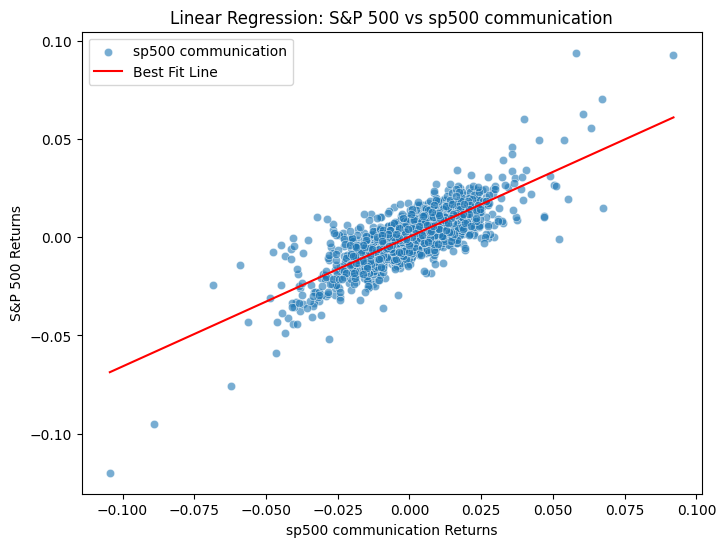

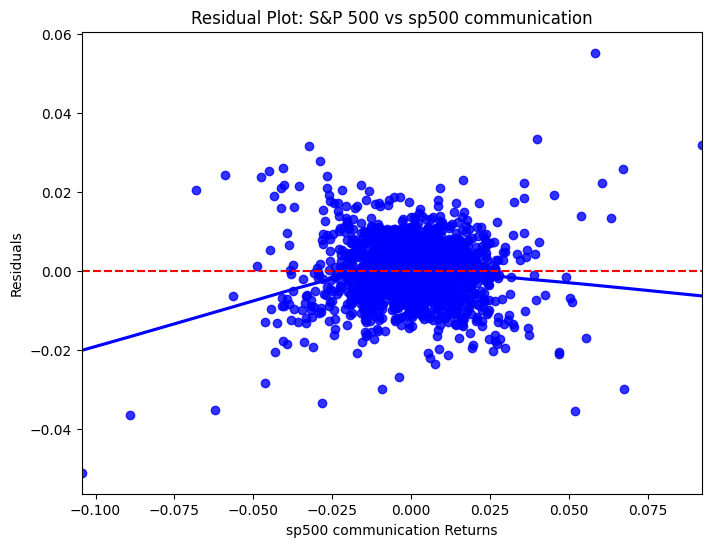

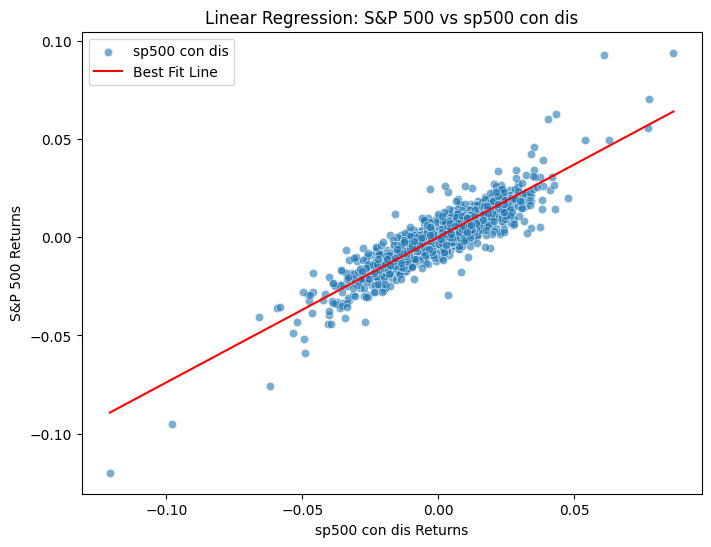

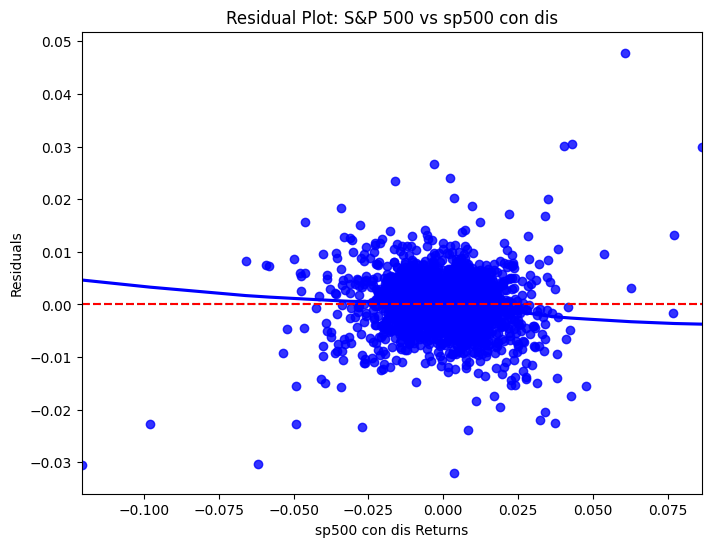

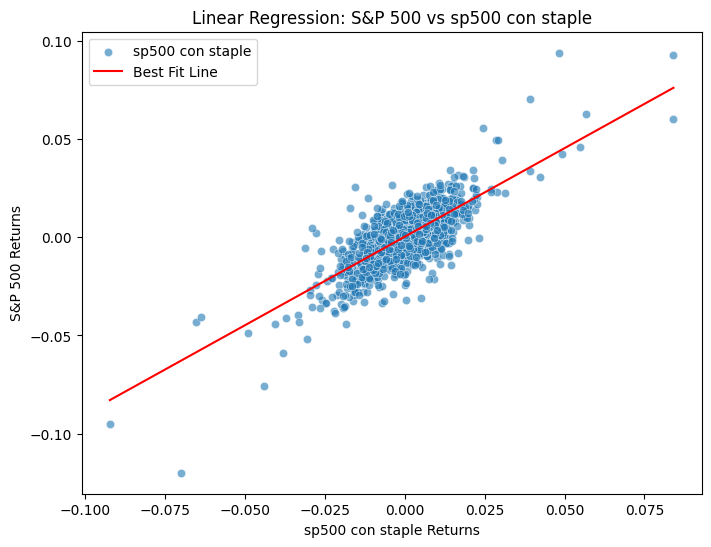

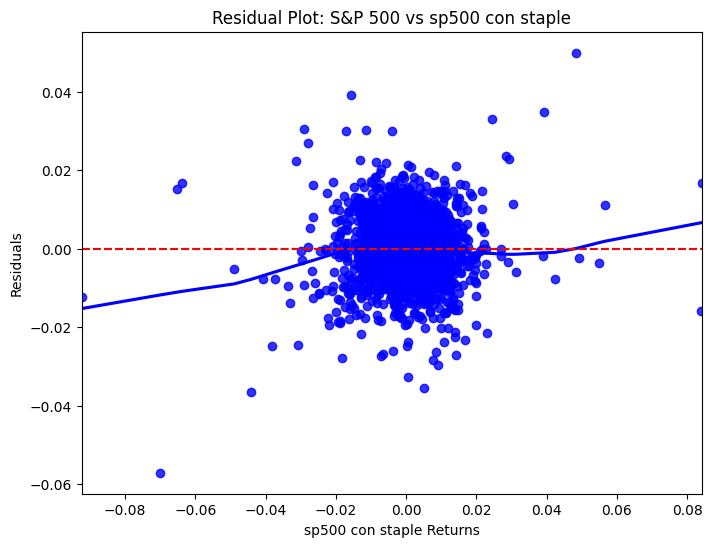

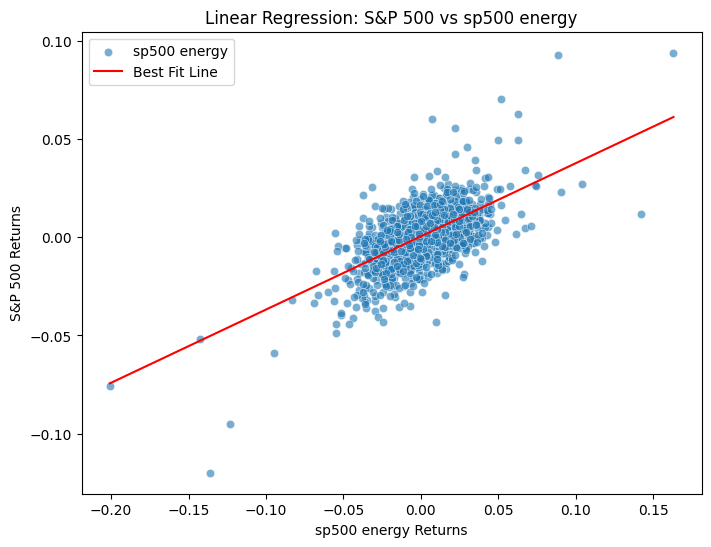

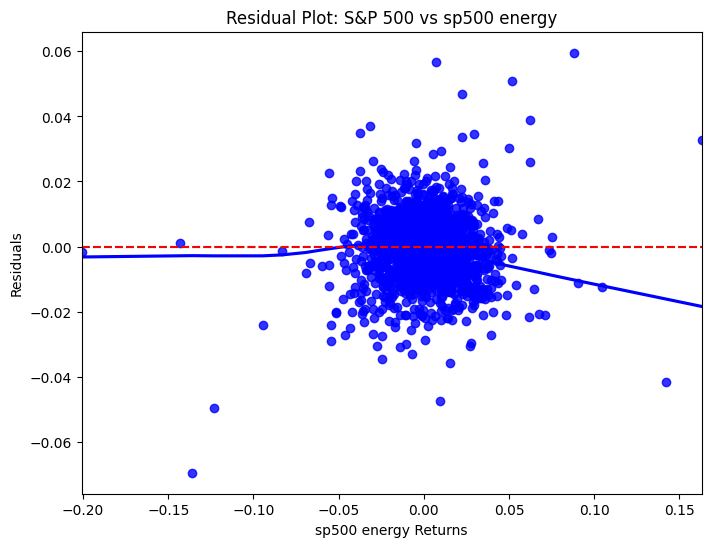

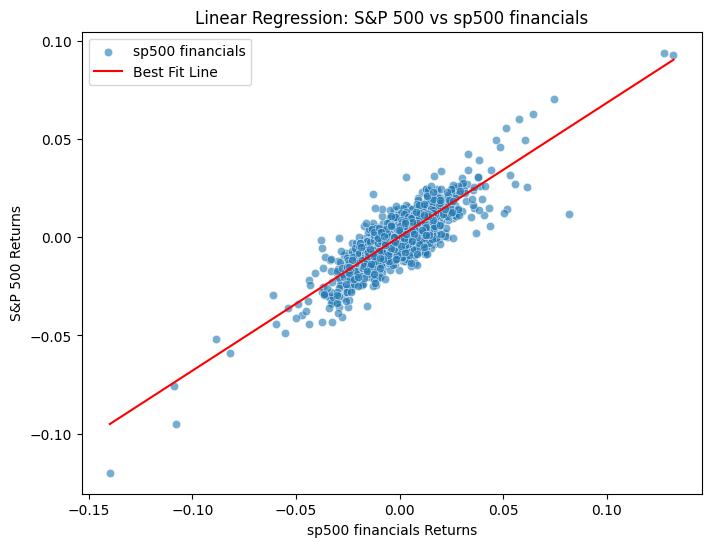

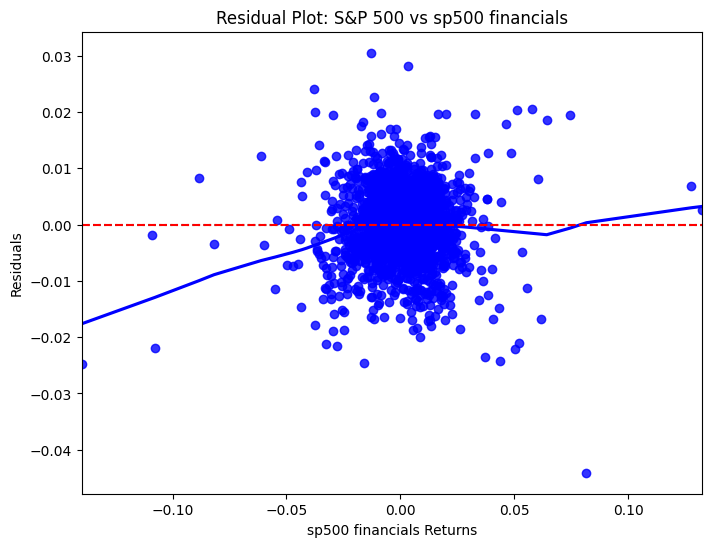

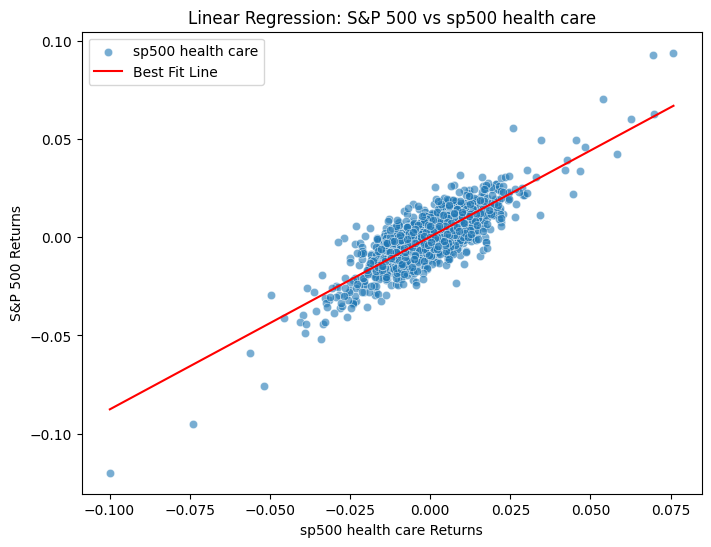

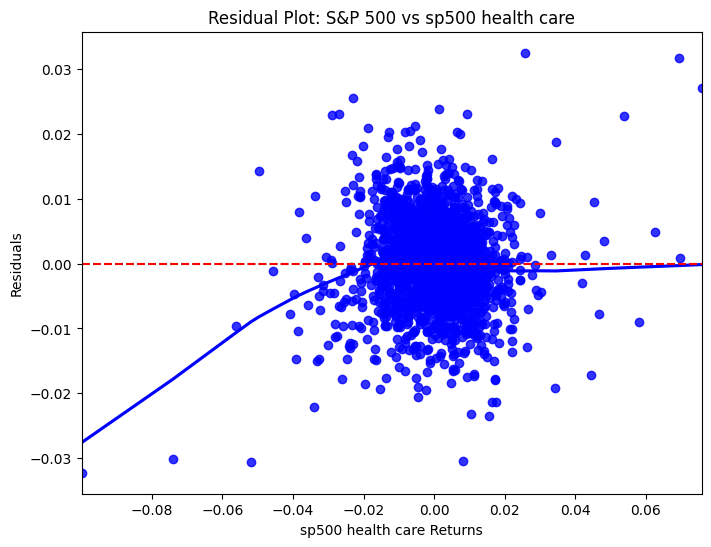

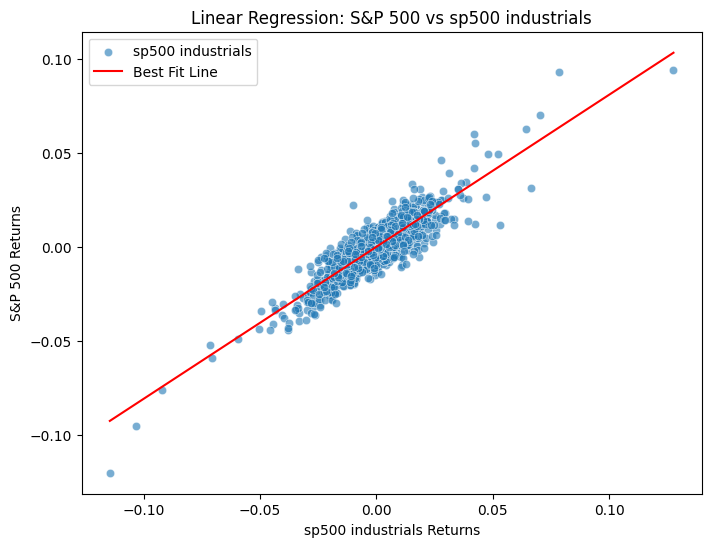

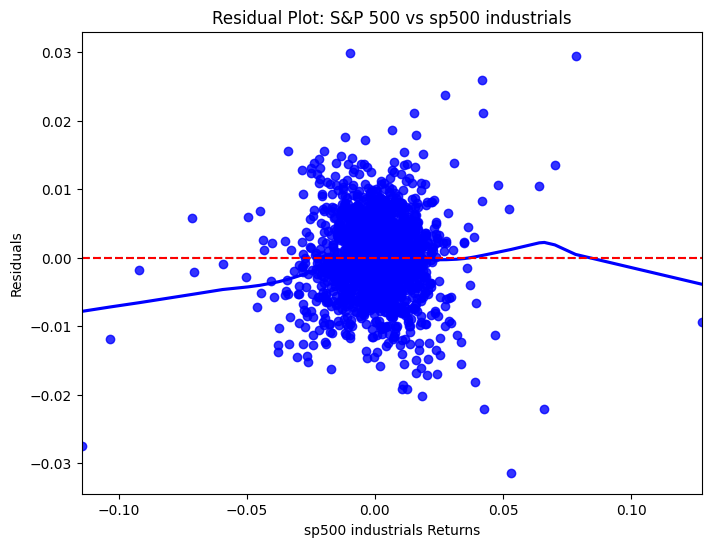

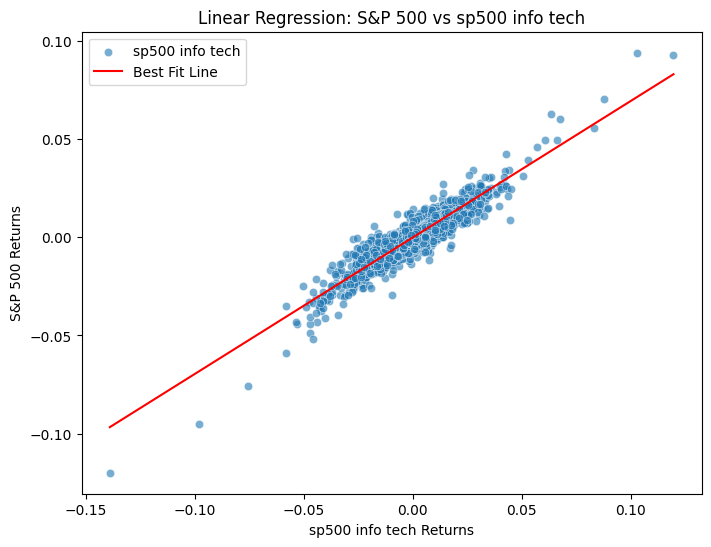

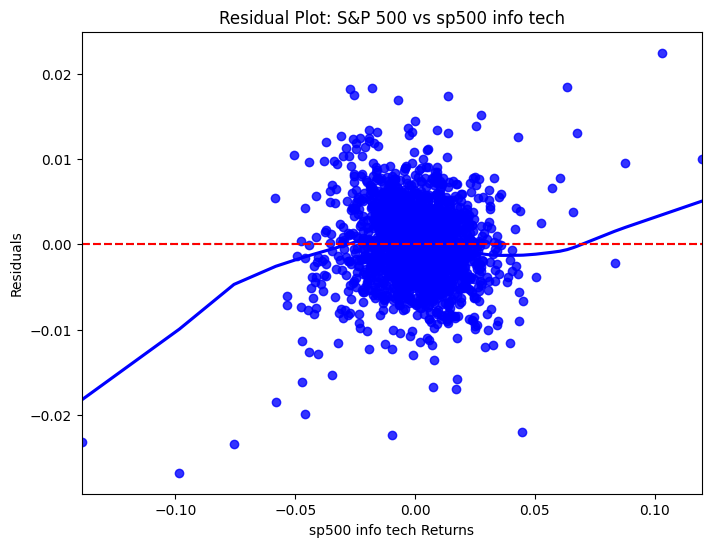

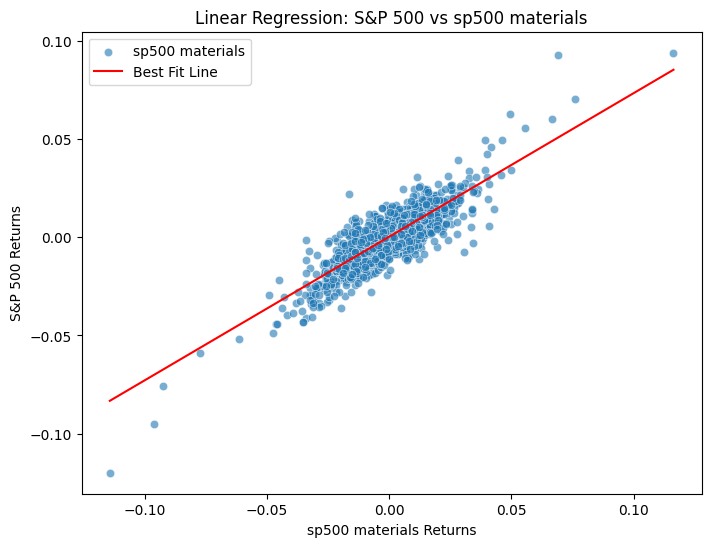

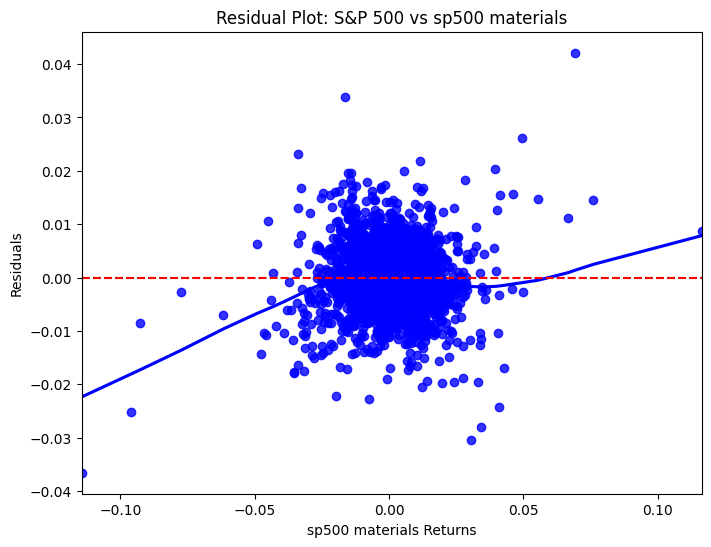

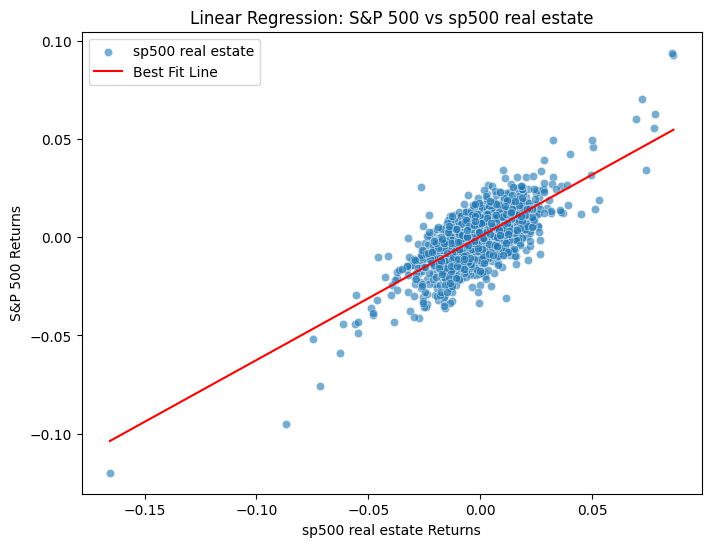

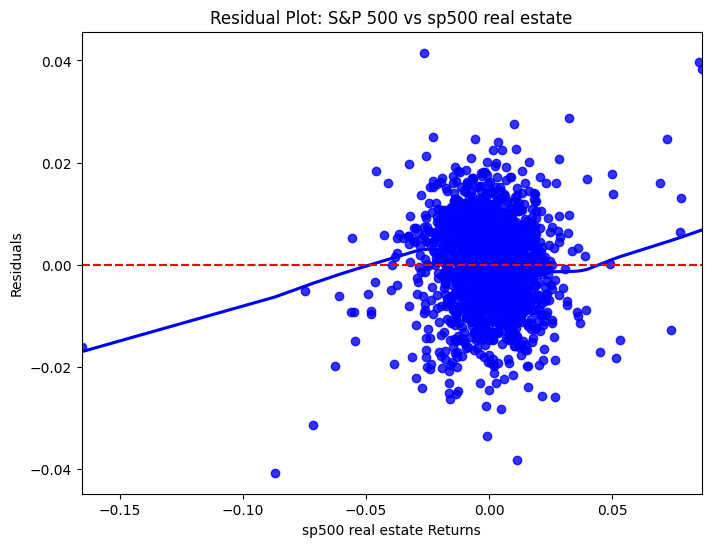

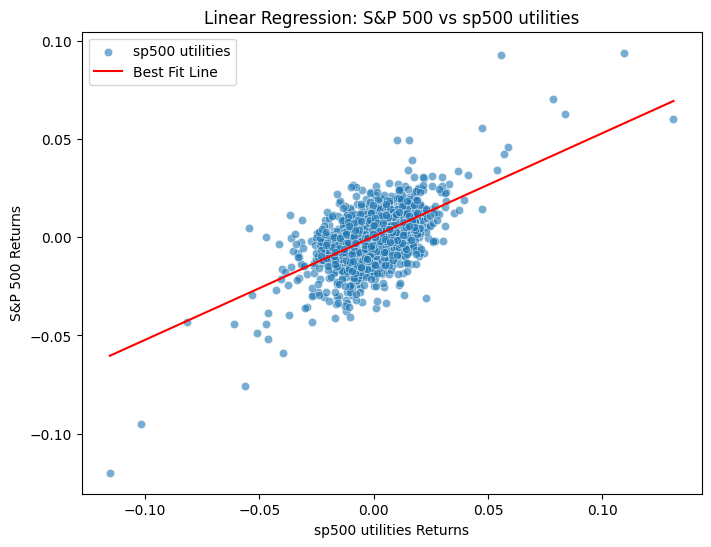

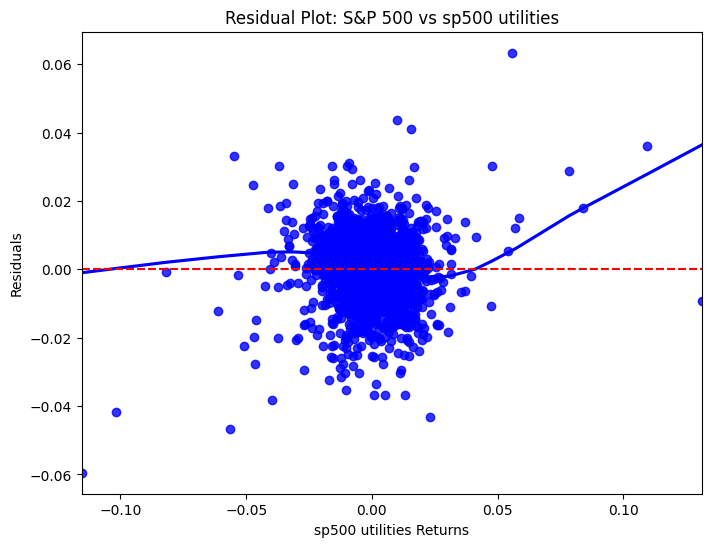

In [9]:
#Running the LR
results = {}

for sector, data in sp500_sector.items():
    combined = pd.merge(sp500[["Return"]], data[["Return"]], left_index=True, right_index=True, suffixes=('_sp500', f'_{sector}'))
    
    X = combined[f"Return_{sector}"]
    Y = combined["Return_sp500"]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    results[sector] = model

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=f"Return_{sector}", y="Return_sp500", data=combined, alpha=0.6, label=sector)
    sns.lineplot(x=combined[f"Return_{sector}"], y=model.predict(X), color="red", label="Best Fit Line")
    plt.title(f"Linear Regression: S&P 500 vs {sector}")
    plt.xlabel(f"{sector} Returns")
    plt.ylabel("S&P 500 Returns")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.residplot(x=combined[f"Return_{sector}"], y=Y - model.predict(X), lowess=True, color="blue")
    plt.axhline(0, color="red", linestyle="--")
    plt.title(f"Residual Plot: S&P 500 vs {sector}")
    plt.xlabel(f"{sector} Returns")
    plt.ylabel("Residuals")
    plt.show()

In [10]:
#Testing for Heteroskedasticity

for sector, model in results.items():
    bp_test = het_breuschpagan(model.resid, model.model.exog)
    print(f"Heteroskedasticity Test for {sector}:")
    print(f"  LM Statistic: {bp_test[0]}, p-value: {bp_test[1]} (Low p-value indicates heteroskedasticity)")

Heteroskedasticity Test for sp500 communication:
  LM Statistic: 14.346275608216752, p-value: 0.00015208023984728436 (Low p-value indicates heteroskedasticity)
Heteroskedasticity Test for sp500 con dis:
  LM Statistic: 1.8543559701259662, p-value: 0.17327761801465336 (Low p-value indicates heteroskedasticity)
Heteroskedasticity Test for sp500 con staple:
  LM Statistic: 22.20008588303169, p-value: 2.45662807360132e-06 (Low p-value indicates heteroskedasticity)
Heteroskedasticity Test for sp500 energy:
  LM Statistic: 0.3767643211673628, p-value: 0.5393400242907741 (Low p-value indicates heteroskedasticity)
Heteroskedasticity Test for sp500 financials:
  LM Statistic: 4.403761356972946, p-value: 0.03585975716523838 (Low p-value indicates heteroskedasticity)
Heteroskedasticity Test for sp500 health care:
  LM Statistic: 20.510393168690367, p-value: 5.93083426722986e-06 (Low p-value indicates heteroskedasticity)
Heteroskedasticity Test for sp500 industrials:
  LM Statistic: 17.00841584054